# Lab (2): Improving the training pipeline
In Lab (1), we develop a simplified training pipeline. To obtain better training result, we will improve the training pipeline by employing data augmentation, improving the model design, and tuning the hyperparameters.\
Before start, please duplicate the notebook in Lab (1) and name it as simplenn-cifar10-dev.ipynb, and work on the new notebook. You goal is to reach at least 70% validation accuracy on the CIFAR-10 dataset.

### Step 0: Set up the SimpleNN model
As you have practiced to implement simple neural networks in Homework 1, we just prepare the implementation for you.

In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# define the SimpleNN mode;
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

## Question (a)
Data augmentation techniques help combat overfitting. A typical strategy for CIFAR classifica- tion is to combine 1) random cropping with a padding of 4 and 2) random flipping. Train a model with such augmentation. How is the validation accuracy compared with the one without augmentation? Note that in the following questions we all use augmentation. Also remember to reinitialize the model whenever you start a new training!

### Step 1: Set up preprocessing functions
Preprocessing is very important as discussed in the lecture.
You will need to write preprocessing functions with the help of *torchvision.transforms* in this step.
You can find helpful tutorial/API at [here](https://pytorch.org/vision/stable/transforms.html).

In [3]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
transform_train_aug = transforms.Compose(
    [
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))]
)

transform_val_aug = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
    ]
)
#############################################

In [4]:
# specify preprocessing function without data augmentation
transform_train_basic = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))]
)

transform_val_basic = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
    ]
)
#############################################

### Step 2: Set up dataset and dataloader

In [5]:
# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset with data augmentation
train_set_aug = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train_aug    
)
val_set_aug = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val_aug    
)

# construct dataloader
train_loader_aug = DataLoader(
    train_set_aug, 
    batch_size=TRAIN_BATCH_SIZE,  
    shuffle=True,    
    num_workers=4
)
val_loader_aug = DataLoader(
    val_set_aug, 
    batch_size=VAL_BATCH_SIZE,  
    shuffle=False,     
    num_workers=4
)

# construct dataset without data augmentation
train_set_basic = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train_basic    
)
val_set_basic = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val_basic   
)

# construct dataloader without data augmentation
train_loader_basic = DataLoader(
    train_set_basic, 
    batch_size=TRAIN_BATCH_SIZE,  
    shuffle=True,     
    num_workers=4
)

val_loader_basic = DataLoader(
    val_set_basic, 
    batch_size=VAL_BATCH_SIZE,  
    shuffle=False,     
    num_workers=4
)
#############################################

Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


### Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.

In [6]:
# initialize the model
net = SimpleNN()

# specify the device for computation
#############################################
# check the device 
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = net.to(device)
    print("Model deployed on GPU.")
else:
    device = torch.device("cpu")
    model = net.to(device)
    print("Model deployed on CPU.")

#############################################

Model deployed on GPU.


### Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum. 

In [7]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add optimizer
optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

### Step 5: Start the training process.

In [8]:
def train_test_NN(train_loader, val_loader, model, epoch, lr, optimizer, criterion, device, checkpoint_folder):
    # start the training/validation process
    # the process should take about 5 minutes on a GTX 1070-Ti
    # if the code is written efficiently.
    best_val_acc = 0
    current_learning_rate = lr

    print("==> Training starts!")
    print("="*50)

    l_train_acc = []
    l_train_loss = []
    l_val_acc = []
    l_val_loss = []

    for i in range(1, epoch+1):
        
        #######################
        # your code here
        # switch to train mode
        model.train()
        
        #######################
        
        # this help you compute the training accuracy
        total_examples = 0
        correct_examples = 0

        train_loss = 0 # track training loss if you want

        
        # Train the model for 1 epoch.
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # compute the output and loss
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # zero the gradient
            optimizer.zero_grad()
            
            # backpropagation
            loss.backward()
            
            # apply gradient and update the weights
            optimizer.step()
            
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()
            
            # add to totals
            train_loss += loss.item()
            total_examples += targets.size(0)
            correct_examples += correct.item()
            ####################################
                    
        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        l_train_acc.append(avg_acc)
        l_train_loss.append(avg_loss)
        # print every 10 epochs
        if i % 10 == 0 or i == 1:
            print(f"EPOCH: {i}, Training loss: {avg_loss:.4f}, Training accuracy: {avg_acc:.4f}")
            
        # Validate on the validation dataset
        #######################
        # your code here
        # switch to eval mode
        model.eval()
        
        #######################

        # this help you compute the validation accuracy
        total_examples = 0
        correct_examples = 0
        
        val_loss = 0 # again, track the validation loss if you want

        # disable gradient during validation, which can save GPU memory
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                ####################################
                # your code here
                # copy inputs to device
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                # compute the output and loss
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # count the number of correctly predicted samples in the current batch
                _, predicted = torch.max(outputs, 1)
                correct = predicted.eq(targets).sum()
                
                # add to totals
                val_loss += loss.item()
                total_examples += targets.size(0)
                correct_examples += correct.item()
                ####################################

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        l_val_loss.append(avg_loss)
        l_val_acc.append(avg_acc)
        # print every 10 epochs
        if i % 10 == 0 or i == 1:
            print(f"EPOCH: {i}, Validation loss: {avg_loss:.4f}, Validation accuracy: {avg_acc:.4f}")
        
        # save the model checkpoint
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(checkpoint_folder):
                os.makedirs(checkpoint_folder)
            # print("Saving ...")
            state = {'state_dict': model.state_dict(),
                    'epoch': i,
                    'lr': current_learning_rate}
            torch.save(state, os.path.join(checkpoint_folder, 'simplenn.pth'))
            
        # print('')

    print("="*50)
    print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")
    return l_train_acc, l_train_loss, l_val_acc, l_val_loss

In [9]:
# reset the model weights
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.BatchNorm2d):
        m.reset_parameters()

In [48]:
# some hyperparameters
# total number of training epochs
EPOCHS = 30

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start training model without data augmentation
l_train_acc_basic, _, l_val_acc_basic, _ = train_test_NN(
    train_loader_basic, 
    val_loader_basic, 
    model, 
    EPOCHS, 
    INITIAL_LR, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER
)

==> Training starts!
EPOCH: 1, Training loss: 1.8517, Training accuracy: 0.3214
EPOCH: 1, Validation loss: 1.5441, Validation accuracy: 0.4468
EPOCH: 10, Training loss: 0.7527, Training accuracy: 0.7371
EPOCH: 10, Validation loss: 1.0405, Validation accuracy: 0.6586
EPOCH: 20, Training loss: 0.4139, Training accuracy: 0.8511
EPOCH: 20, Validation loss: 1.3885, Validation accuracy: 0.6332
EPOCH: 30, Training loss: 0.2673, Training accuracy: 0.9056
EPOCH: 30, Validation loss: 1.9181, Validation accuracy: 0.6278
==> Optimization finished! Best validation accuracy: 0.6592


In [49]:
# initialize model with data augmentation
model_with_aug = SimpleNN().to(device)

# hyperparameters
# initial learning rate
INITIAL_LR = 0.01

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-4

#############################################
# create loss function
criterion = nn.CrossEntropyLoss().to(device)

# Add optimizer
optimizer = optim.SGD(model_with_aug.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)
#############################################

# total number of training epochs
EPOCHS = 30

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start training model with data augmentation
l_train_acc_aug, _, l_val_acc_aug, _ = train_test_NN(
    train_loader_aug, 
    val_loader_aug, 
    model_with_aug, 
    EPOCHS, 
    INITIAL_LR, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER
)

==> Training starts!
EPOCH: 1, Training loss: 1.9692, Training accuracy: 0.2719
EPOCH: 1, Validation loss: 1.7044, Validation accuracy: 0.3926
EPOCH: 10, Training loss: 1.1161, Training accuracy: 0.6004
EPOCH: 10, Validation loss: 1.0545, Validation accuracy: 0.6348
EPOCH: 20, Training loss: 0.9733, Training accuracy: 0.6560
EPOCH: 20, Validation loss: 0.9265, Validation accuracy: 0.6762
EPOCH: 30, Training loss: 0.9052, Training accuracy: 0.6820
EPOCH: 30, Validation loss: 0.8881, Validation accuracy: 0.6894
==> Optimization finished! Best validation accuracy: 0.6970


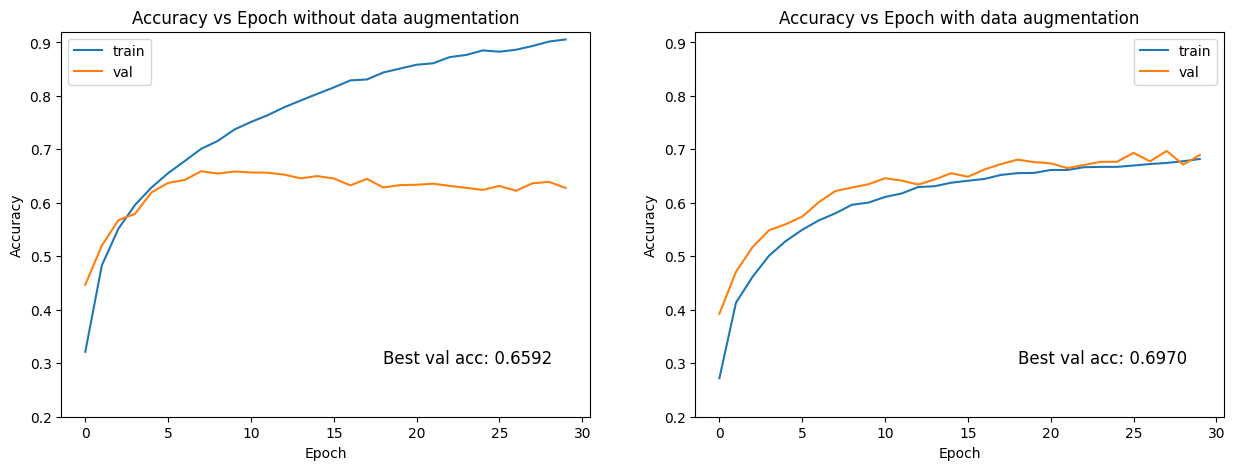

In [50]:
# plot the training curve of both models in two subplots with and without data augmentation
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(np.arange(EPOCHS), l_train_acc_basic, label='train')
ax1.plot(np.arange(EPOCHS), l_val_acc_basic, label='val')
ax1.set_ylim([0.2, 0.92])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Epoch without data augmentation')
ax1.text(s=f"Best val acc: {np.max(l_val_acc_basic):.4f}", x=18, y=0.3, fontsize=12)
ax1.legend()
ax2.plot(np.arange(EPOCHS), l_train_acc_aug, label='train')
ax2.plot(np.arange(EPOCHS), l_val_acc_aug, label='val')
ax2.set_ylim([0.2, 0.92])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Epoch with data augmentation')
ax2.text(s=f"Best val acc: {np.max(l_val_acc_aug):.4f}", x=18, y=0.3, fontsize=12)
ax2.legend()
plt.show()


## Question (b)

Model design is another important factor in determining performance on a given task. Now, modify the design of SimpleNN as instructed below:

- (5 pts) Add a batch normalization (BN) layer after each convolution layer. Compared with no BN layers, how does the best validation accuracy change?

- (5 pts) Use empirical results to show that batch normalization allows a larger learning rate.

- (5 pts) Implement Swish [2] activation on you own, and replace all of the ReLU activations in SimpleNN to Swish. Train the model with BN layers and a learning rate of 0.1. Does Swish outperform ReLU?

In [10]:
# define the SimpleNN mode;
class SimpleNN_with_BN(nn.Module):
    def __init__(self):
        super(SimpleNN_with_BN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [11]:
# initialize model with batch normalization
model_with_BN = SimpleNN_with_BN().to(device)

# hyperparameters
INITIAL_LR = 0.01
MOMENTUM = 0.9
REG = 1e-4

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model_with_BN.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

# start training model with batch normalization
l_train_acc_with_BN, _, l_val_acc_with_BN, _ = train_test_NN(
    train_loader_aug, 
    val_loader_aug, 
    model_with_BN, 
    EPOCHS, 
    INITIAL_LR, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER
)

==> Training starts!
EPOCH: 1, Training loss: 1.7618, Training accuracy: 0.3423
EPOCH: 1, Validation loss: 1.4678, Validation accuracy: 0.4562
EPOCH: 10, Training loss: 1.0369, Training accuracy: 0.6315
EPOCH: 10, Validation loss: 0.9933, Validation accuracy: 0.6472
EPOCH: 20, Training loss: 0.9131, Training accuracy: 0.6770
EPOCH: 20, Validation loss: 0.8686, Validation accuracy: 0.6948
EPOCH: 30, Training loss: 0.8436, Training accuracy: 0.7007
EPOCH: 30, Validation loss: 0.8104, Validation accuracy: 0.7144
==> Optimization finished! Best validation accuracy: 0.7144


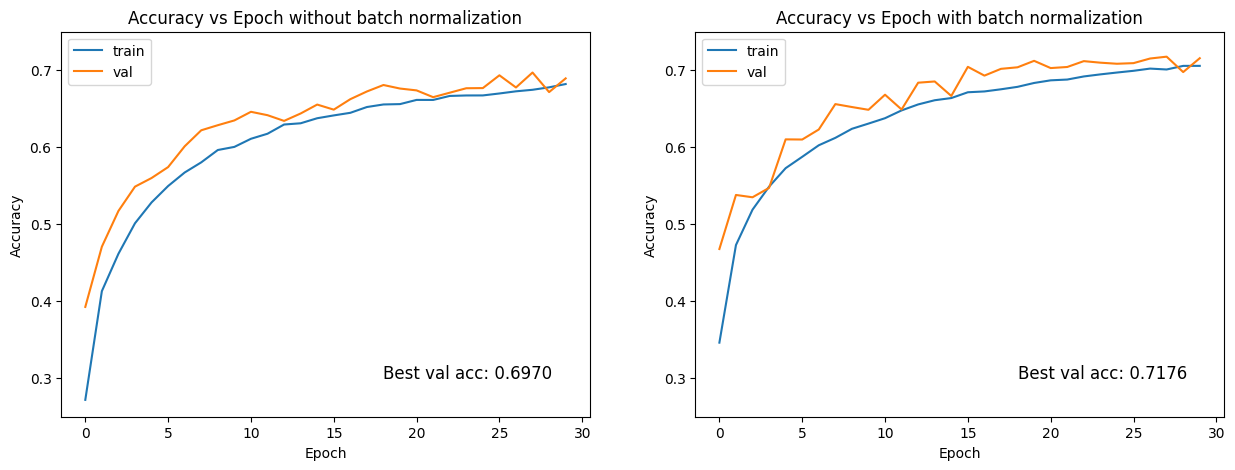

In [53]:
# plot the training curve of both models in two subplots with and without batch normalization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(np.arange(EPOCHS), l_train_acc_aug, label='train')
ax1.plot(np.arange(EPOCHS), l_val_acc_aug, label='val')
ax1.set_ylim([0.25, 0.75])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Epoch without batch normalization')
ax1.text(s=f"Best val acc: {np.max(l_val_acc_aug):.4f}", x=18, y=0.3, fontsize=12)
ax1.legend()

ax2.plot(np.arange(EPOCHS), l_train_acc_with_BN, label='train')
ax2.plot(np.arange(EPOCHS), l_val_acc_with_BN, label='val')
ax2.set_ylim([0.25, 0.75])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Epoch with batch normalization')
ax2.text(s=f"Best val acc: {np.max(l_val_acc_with_BN):.4f}", x=18, y=0.3, fontsize=12)
ax2.legend()
plt.show()


**Increasing learning rate:**

In [54]:
# reset the model weights
model_with_BN.apply(weight_reset)

# increase learning rate from 0.01 to 0.1
LR_2 = 0.1

l_train_acc_with_BN, _, l_val_acc_with_BN, _ = train_test_NN(
    train_loader_aug, 
    val_loader_aug, 
    model_with_BN, 
    EPOCHS, 
    LR_2, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER
)

==> Training starts!
EPOCH: 1, Training loss: 1.7408, Training accuracy: 0.3528
EPOCH: 1, Validation loss: 1.4945, Validation accuracy: 0.4490
EPOCH: 10, Training loss: 1.0326, Training accuracy: 0.6347
EPOCH: 10, Validation loss: 0.9419, Validation accuracy: 0.6628
EPOCH: 20, Training loss: 0.9030, Training accuracy: 0.6806
EPOCH: 20, Validation loss: 0.8701, Validation accuracy: 0.6926
EPOCH: 30, Training loss: 0.8430, Training accuracy: 0.7022
EPOCH: 30, Validation loss: 0.8030, Validation accuracy: 0.7202
==> Optimization finished! Best validation accuracy: 0.7202


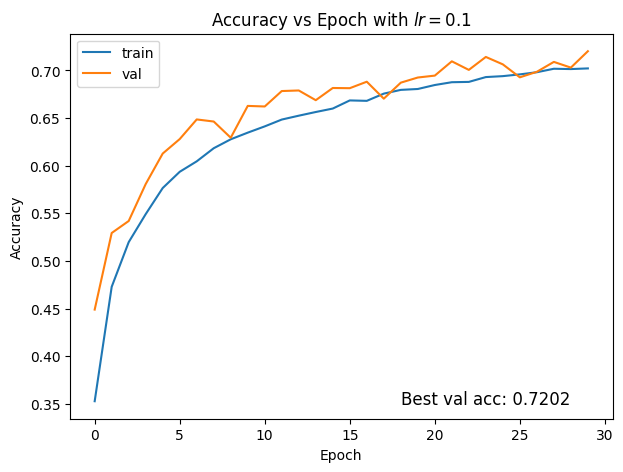

In [55]:
# plot the training curve 
plt.figure(figsize=(7, 5))
plt.plot(np.arange(EPOCHS), l_train_acc_with_BN, label='train')
plt.plot(np.arange(EPOCHS), l_val_acc_with_BN, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch with $lr=0.1$')
plt.text(s=f"Best val acc: {np.max(l_val_acc_with_BN):.4f}", x=18, y=0.35, fontsize=12)
plt.legend()
plt.show()

Comment: With batch normalization, increasing learning rate to 0.1 will still achieve good model performance with best validation accuracy reaching 0.7166.

**Change ReLU to Swish:**

Swish function: $$\alpha(x) = x\sigma(x)$$

In [12]:
def swish(x):
    return x * torch.sigmoid(x)

In [13]:
# define the SimpleNN mode;
class SimpleNN_swish(nn.Module):
    def __init__(self):
        super(SimpleNN_swish, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = swish(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, 2)
        out = swish(self.bn2(self.conv2(out)))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [58]:
# initialize model with swish activation function
model_swish = SimpleNN_swish().to(device)

# hyperparameters
INITIAL_LR = 0.01
MOMENTUM = 0.9
REG = 1e-4

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model_swish.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

l_train_acc_swish, _, l_val_acc_swish, _ = train_test_NN(
    train_loader_aug, 
    val_loader_aug, 
    model_swish, 
    EPOCHS, 
    LR_2, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER
)

==> Training starts!
EPOCH: 1, Training loss: 1.7778, Training accuracy: 0.3438
EPOCH: 1, Validation loss: 1.4628, Validation accuracy: 0.4700
EPOCH: 10, Training loss: 1.0154, Training accuracy: 0.6416
EPOCH: 10, Validation loss: 0.9812, Validation accuracy: 0.6492
EPOCH: 20, Training loss: 0.8850, Training accuracy: 0.6874
EPOCH: 20, Validation loss: 0.8657, Validation accuracy: 0.7024
EPOCH: 30, Training loss: 0.8146, Training accuracy: 0.7121
EPOCH: 30, Validation loss: 0.8081, Validation accuracy: 0.7206
==> Optimization finished! Best validation accuracy: 0.7300


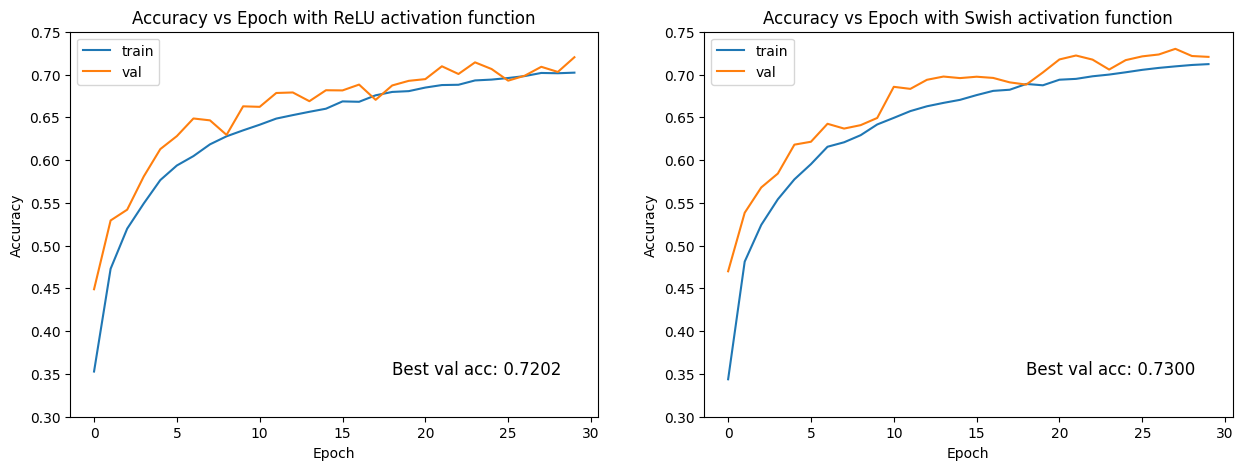

In [59]:
# plot the training curve of both models in two subplots with ReLU and Swish activation functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(np.arange(EPOCHS), l_train_acc_with_BN, label='train')
ax1.plot(np.arange(EPOCHS), l_val_acc_with_BN, label='val')
ax1.set_ylim([0.3, 0.75])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Epoch with ReLU activation function')
ax1.text(s=f"Best val acc: {np.max(l_val_acc_with_BN):.4f}", x=18, y=0.35, fontsize=12)
ax1.legend()

ax2.plot(np.arange(EPOCHS), l_train_acc_swish, label='train')
ax2.plot(np.arange(EPOCHS), l_val_acc_swish, label='val')
ax2.set_ylim([0.3, 0.75])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Epoch with Swish activation function')
ax2.text(s=f"Best val acc: {np.max(l_val_acc_swish):.4f}", x=18, y=0.35, fontsize=12)
ax2.legend()
plt.show()

## Question(c) (14 pts) 
Hyperparameter settings are very important and can have a large impact on the final model performance. Based on the improvements that you have made to the training pipeline thus far (with data augmentation and BN layers), tune some of the hyperparameters as instructed below:

- (7 pts) Apply different learning rate values: 1.0, 0.1, 0.05, 0.01, 0.005, 0.001, to see how the learning rate affects the model performance, and report results for each. Is a large learning rate beneficial for model training? If not, what can you conclude from the choice of learning rate?

- (7 pts) Use different L2 regularization strengths of 1e-2, 1e-3, 1e-4, 1e-5, and 0.0 to see how the L2 regularization strength affects the model performance. In this problem use a learning rate of 0.01. Report the results for each regularization strength value along with comments on the importance of this hyperparameter.

- (Bonus, 6 pts) Switch the regularization penalty from L2 penalty to L1 penalty. This means you may not use the weight_decay parameter in PyTorch builtin optimizers, as it does not support L1 regularization. Instead, you need to add L1 penalty as a part of the loss function. Compare the distribution of weight parameters after L1/L2 regularization. Describe your observations.


1. Tuning learning rate:

In [24]:
l_LR = [1, 0.1, 0.05, 0.01, 0.005, 0.001]
lr_val_acc = []

# hyperparameters
MOMENTUM = 0.9
REG = 1e-4
criterion = nn.CrossEntropyLoss().to(device)
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

for lr in l_LR:
    print(f"==> Current learning rate is: {lr}")

    # initialize model with swish activation function
    model = SimpleNN_swish().to(device)
    model.apply(weight_reset)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=REG)

    # start training model with different learning rates
    _, _, l_val_acc, _ = train_test_NN( 
        train_loader_aug, 
        val_loader_aug, 
        model, 
        EPOCHS, 
        lr, 
        optimizer, 
        criterion, 
        device, 
        CHECKPOINT_FOLDER
    )

    # save the validation accuracy list
    lr_val_acc.append(l_val_acc)
    

==> Current learning rate is: 1
==> Training starts!
EPOCH: 1, Training loss: nan, Training accuracy: 0.1035
EPOCH: 1, Validation loss: nan, Validation accuracy: 0.1028
EPOCH: 10, Training loss: nan, Training accuracy: 0.0999
EPOCH: 10, Validation loss: nan, Validation accuracy: 0.1028
EPOCH: 20, Training loss: nan, Training accuracy: 0.0999
EPOCH: 20, Validation loss: nan, Validation accuracy: 0.1028
EPOCH: 30, Training loss: nan, Training accuracy: 0.0999
EPOCH: 30, Validation loss: nan, Validation accuracy: 0.1028
==> Optimization finished! Best validation accuracy: 0.1028
==> Current learning rate is: 0.1
==> Training starts!
EPOCH: 1, Training loss: 1.6753, Training accuracy: 0.3800
EPOCH: 1, Validation loss: 1.4440, Validation accuracy: 0.4724
EPOCH: 10, Training loss: 1.0602, Training accuracy: 0.6292
EPOCH: 10, Validation loss: 0.9964, Validation accuracy: 0.6494
EPOCH: 20, Training loss: 0.9499, Training accuracy: 0.6698
EPOCH: 20, Validation loss: 0.9751, Validation accuracy:

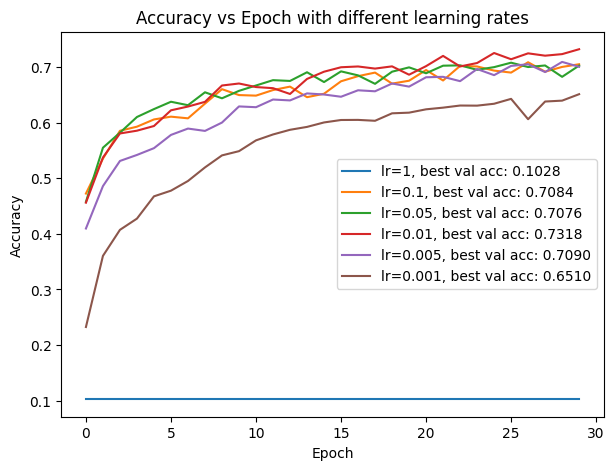

In [26]:
# plot the six learning curves in one figure
plt.figure(figsize=(7, 5))
for i, lr in enumerate(l_LR):
    plt.plot(np.arange(EPOCHS), lr_val_acc[i], label=f'lr={lr}, best val acc: {np.max(lr_val_acc[i]):.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch with different learning rates')
plt.legend()
plt.show()

2. Tuning L2 regularization strength:

In [18]:
l_REG = [1e-2, 1e-3, 1e-4, 1e-5, 0]
l2_reg_val_acc = []

# hyperparameters
MOMENTUM = 0.9
INITIAL_LR = 0.01
criterion = nn.CrossEntropyLoss().to(device)
EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

for reg in l_REG:
    print(f"==> Current L2 regularization strength is: {reg}")
    # initialize model with swish activation function
    model = SimpleNN_swish().to(device)
    model.apply(weight_reset)
    optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=reg)

    # start training model with different learning rates
    _, _, l_val_acc, _ = train_test_NN(
        train_loader_aug, 
        val_loader_aug, 
        model, 
        EPOCHS, 
        INITIAL_LR, 
        optimizer, 
        criterion, 
        device, 
        CHECKPOINT_FOLDER
    )

    # save the best validation accuracy
    l2_reg_val_acc.append(l_val_acc)
    

==> Current L2 regularization strength is: 0.01
==> Training starts!
EPOCH: 1, Training loss: 1.8111, Training accuracy: 0.3198
EPOCH: 1, Validation loss: 1.5441, Validation accuracy: 0.4208
EPOCH: 10, Training loss: 1.2538, Training accuracy: 0.5538
EPOCH: 10, Validation loss: 1.2546, Validation accuracy: 0.5584
EPOCH: 20, Training loss: 1.1796, Training accuracy: 0.5865
EPOCH: 20, Validation loss: 1.1235, Validation accuracy: 0.6026
EPOCH: 30, Training loss: 1.1509, Training accuracy: 0.5971
EPOCH: 30, Validation loss: 1.1260, Validation accuracy: 0.6120
==> Optimization finished! Best validation accuracy: 0.6244
==> Current L2 regularization strength is: 0.001
==> Training starts!
EPOCH: 1, Training loss: 1.7808, Training accuracy: 0.3398
EPOCH: 1, Validation loss: 1.4509, Validation accuracy: 0.4570
EPOCH: 10, Training loss: 1.0427, Training accuracy: 0.6300
EPOCH: 10, Validation loss: 1.0072, Validation accuracy: 0.6432
EPOCH: 20, Training loss: 0.9161, Training accuracy: 0.6802
E

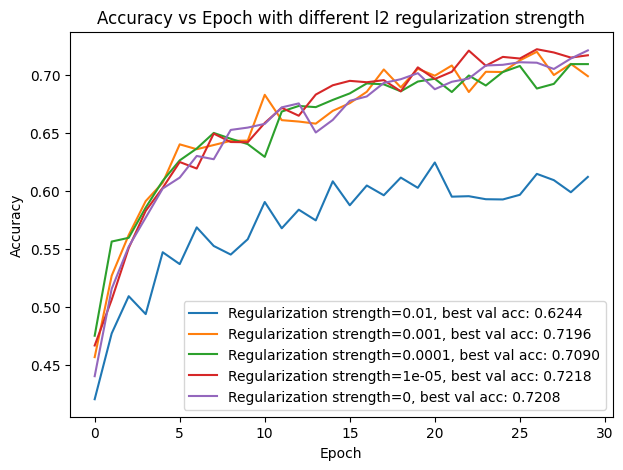

In [20]:
# plot the six learning curves in one figure
plt.figure(figsize=(7, 5))
for i, reg in enumerate(l_REG):
    plt.plot(np.arange(EPOCHS), l2_reg_val_acc[i], label=f'Regularization strength={reg}, best val acc: {np.max(l2_reg_val_acc[i]):.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch with different l2 regularization strength')
plt.legend()
plt.show()

Switch to L1 regularization

In [66]:
def train_test_L1(train_loader, val_loader, model, epoch, lr, l1_lamda, optimizer, criterion, device, checkpoint_folder):
    # start the training/validation process
    # the process should take about 5 minutes on a GTX 1070-Ti
    # if the code is written efficiently.
    best_val_acc = 0
    current_learning_rate = lr

    print("==> Training starts!")
    print("="*50)

    l_train_acc = []
    l_train_loss = []
    l_val_acc = []
    l_val_loss = []

    for i in range(0, epoch):
        
        #######################
        # your code here
        # switch to train mode
        model.train()

        #######################
        
        print("Epoch %d:" %i)
        # this help you compute the training accuracy
        total_examples = 0
        correct_examples = 0

        train_loss = 0 # track training loss if you want

        
        # Train the model for 1 epoch.
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # compute the output and loss
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # zero the gradient
            optimizer.zero_grad()
            
            # compute L1 regularization loss
            l1_reg = torch.tensor(0.).to(device)
            for name, param in model.named_parameters():
                if 'bias' not in name:
                    l1_reg += torch.norm(param, 1)
            loss += l1_lamda * l1_reg

            # backpropagation
            loss.backward()
            
            # apply gradient and update the weights
            optimizer.step()
            
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()
            
            # add to totals
            train_loss += loss.item()
            total_examples += targets.size(0)
            correct_examples += correct.item()
            ####################################
                    
        avg_loss = train_loss / len(train_loader)
        avg_acc = correct_examples / total_examples
        l_train_acc.append(avg_acc)
        l_train_loss.append(avg_loss)
        print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

        # Validate on the validation dataset
        #######################
        # your code here
        # switch to eval mode
        model.eval()
        
        #######################

        # this help you compute the validation accuracy
        total_examples = 0
        correct_examples = 0
        
        val_loss = 0 # again, track the validation loss if you want

        # disable gradient during validation, which can save GPU memory
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                ####################################
                # your code here
                # copy inputs to device
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                # compute the output and loss
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                # count the number of correctly predicted samples in the current batch
                _, predicted = torch.max(outputs, 1)
                correct = predicted.eq(targets).sum()
                
                # add to totals
                val_loss += loss.item()
                total_examples += targets.size(0)
                correct_examples += correct.item()
                ####################################

        avg_loss = val_loss / len(val_loader)
        avg_acc = correct_examples / total_examples
        l_val_loss.append(avg_loss)
        l_val_acc.append(avg_acc)
        print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
        
        # save the model checkpoint
        if avg_acc > best_val_acc:
            best_val_acc = avg_acc
            if not os.path.exists(checkpoint_folder):
                os.makedirs(checkpoint_folder)
            print("Saving ...")
            state = {'state_dict': net.state_dict(),
                    'epoch': i,
                    'lr': current_learning_rate}
            torch.save(state, os.path.join(checkpoint_folder, 'simplenn.pth'))
            
        print('')

    print("="*50)
    print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")
    return l_train_acc, l_train_loss, l_val_acc, l_val_loss

In [67]:
# initialize model with L1 regularization
model_L1 = SimpleNN_swish().to(device)

# hyperparameters
INITIAL_LR = 0.01
MOMENTUM = 0.9
L1_lAMBDA = 1e-4

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model_L1.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=0)

EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

l_train_acc_L1, _, l_val_acc_L1, _ = train_test_L1(
    train_loader_aug, 
    val_loader_aug, 
    model_L1, 
    EPOCHS, 
    INITIAL_LR, 
    L1_lAMBDA, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER
)

==> Training starts!
Epoch 0:
Training loss: 1.9702, Training accuracy: 0.3456
Validation loss: 1.4260, Validation accuracy: 0.4784
Saving ...

Epoch 1:
Training loss: 1.6163, Training accuracy: 0.4826
Validation loss: 1.3014, Validation accuracy: 0.5276
Saving ...

Epoch 2:
Training loss: 1.4960, Training accuracy: 0.5272
Validation loss: 1.1645, Validation accuracy: 0.5824
Saving ...

Epoch 3:
Training loss: 1.4087, Training accuracy: 0.5563
Validation loss: 1.1980, Validation accuracy: 0.5734

Epoch 4:
Training loss: 1.3448, Training accuracy: 0.5809
Validation loss: 1.0903, Validation accuracy: 0.6116
Saving ...

Epoch 5:
Training loss: 1.3030, Training accuracy: 0.6006
Validation loss: 1.0482, Validation accuracy: 0.6276
Saving ...

Epoch 6:
Training loss: 1.2695, Training accuracy: 0.6102
Validation loss: 1.0166, Validation accuracy: 0.6374
Saving ...

Epoch 7:
Training loss: 1.2389, Training accuracy: 0.6221
Validation loss: 0.9791, Validation accuracy: 0.6582
Saving ...

Epoch 

In [68]:
# intialize model with L2 regularization
model_L2 = SimpleNN_swish().to(device)

# hyperparameters
INITIAL_LR = 0.01
MOMENTUM = 0.9
REG = 1e-4

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model_L2.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

EPOCHS = 30
CHECKPOINT_FOLDER = "./saved_model"

l_train_acc_L2, _, l_val_acc_L2, _ = train_test_NN(
    train_loader_aug, 
    val_loader_aug, 
    model_L2, 
    EPOCHS, 
    INITIAL_LR, 
    optimizer, 
    criterion, 
    device, 
    CHECKPOINT_FOLDER
)

==> Training starts!
EPOCH: 1, Training loss: 1.7795, Training accuracy: 0.3349
EPOCH: 1, Validation loss: 1.4924, Validation accuracy: 0.4598
EPOCH: 10, Training loss: 1.0326, Training accuracy: 0.6338
EPOCH: 10, Validation loss: 1.0932, Validation accuracy: 0.6170
EPOCH: 20, Training loss: 0.9038, Training accuracy: 0.6810
EPOCH: 20, Validation loss: 0.9356, Validation accuracy: 0.6736
EPOCH: 30, Training loss: 0.8408, Training accuracy: 0.7024
EPOCH: 30, Validation loss: 0.8179, Validation accuracy: 0.7108
==> Optimization finished! Best validation accuracy: 0.7122


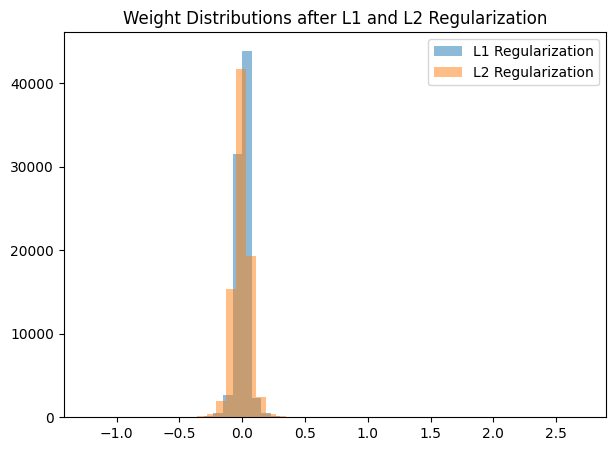

In [69]:
def plot_weight_histogram(model, title):
    all_weights = []
    for param in model.parameters():
        all_weights += list(param.cpu().detach().numpy().flatten())
    plt.hist(all_weights, bins=50, alpha=0.5, label=title)

plt.figure(figsize=(7, 5))
plot_weight_histogram(model_L1, 'L1 Regularization')  # Assuming 'model_swish' is trained with L1
plot_weight_histogram(model_L2, 'L2 Regularization')  # 'model_l2' is a placeholder, replace with your L2-trained model.
plt.title('Weight Distributions after L1 and L2 Regularization')
plt.legend()
plt.show()